Custom QA on PDF using gpt4all / gpt4j - Run on Google Colab Pro( Observed frequent crash when multiple queries are fired).  Need to be modified to use nanogpt / minigpt

In [2]:
# Download gp4all-j-v1.3-groovy model

!wget https://gpt4all.io/models/ggml-gpt4all-j-v1.3-groovy.bin

--2023-11-03 02:52:43--  https://gpt4all.io/models/ggml-gpt4all-j-v1.3-groovy.bin
Resolving gpt4all.io (gpt4all.io)... 172.67.71.169, 104.26.1.159, 104.26.0.159, ...
Connecting to gpt4all.io (gpt4all.io)|172.67.71.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3785248281 (3.5G)
Saving to: ‘ggml-gpt4all-j-v1.3-groovy.bin’

ggml-gpt4all-j-v1.3 100%[===================>]   3.52G  39.9MB/s    in 1m 42s  

2023-11-03 02:54:25 (35.5 MB/s) - ‘ggml-gpt4all-j-v1.3-groovy.bin’ saved [3785248281/3785248281]



In [3]:
# Install the utility for manipulating PDF files

!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.2 [186 kB]
Fetched 186 kB in 1s (364 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.2_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.2) ...
Setting up poppler-utils (22.02.0-2ubuntu0.2) ...
Processing triggers for man-db (2.10.2-1) ...


In [4]:
# Install required libraries

!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain==0.0.173 --progress-bar off
!pip install -qqq chromadb==0.3.23 --progress-bar off
!pip install -qqq pypdf==3.8.1 --progress-bar off
!pip install -qqq pygpt4all==1.1.0 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.
  Preparing metadata (setup.py) ... done


In [5]:
# Download microsoft's financial statement

!gdown 1DpFisoGXsQbpQJvijuvxkLW_pg-FUUMF

Downloading...
From: https://drive.google.com/uc?id=1DpFisoGXsQbpQJvijuvxkLW_pg-FUUMF
To: /content/ms-financial-statement.pdf
100% 29.1k/29.1k [00:00<00:00, 84.7MB/s]


In [6]:
# Import required libraries

from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import GPT4All
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path

# New Section

In [7]:
# Convert PDF statement to image

#images = convert_from_path("./chatgpt/ms-financial-statement.pdf", dpi=88)
images = convert_from_path("./ms-financial-statement.pdf", dpi=88)
len(images)

2

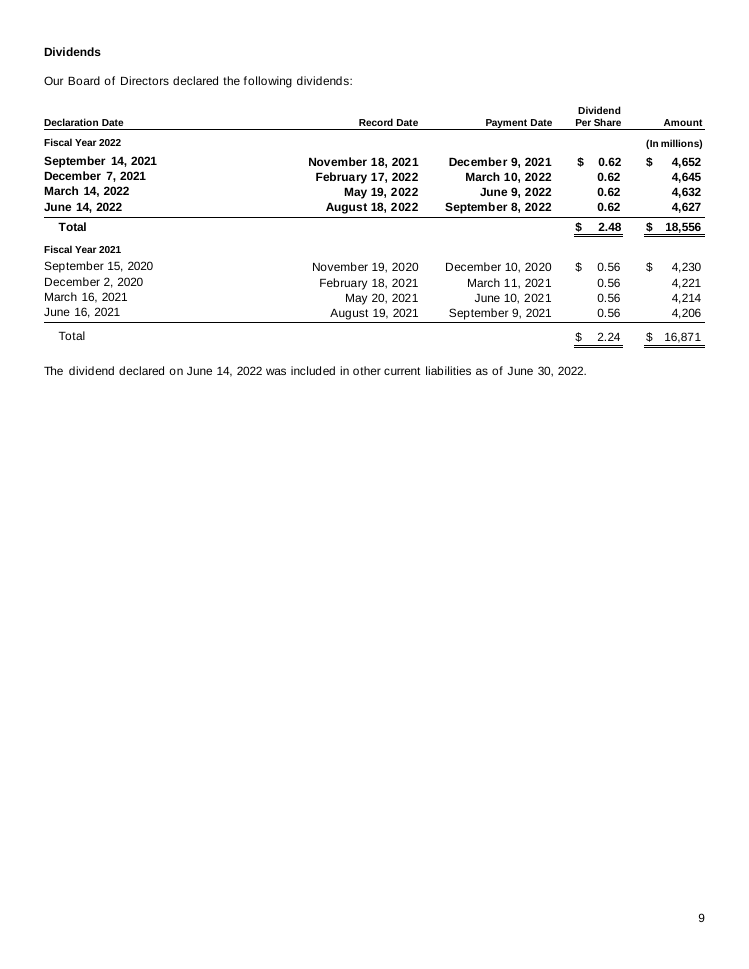

In [8]:
images[0]

In [9]:
# Load the pdf
#loader = PyPDFLoader("./chatgpt/ms-financial-statement.pdf")
loader = PyPDFLoader("./ms-financial-statement.pdf")

In [10]:
documents = loader.load_and_split()

In [11]:
len(documents)

2

In [12]:
# Pring the page contents

print(documents[0].page_content)

9   
Dividends  
Our Board of Directors declared the following dividends:  
  
Declaration Date  Record Date  Payment  Date  Dividend  
Per Share  Amount    
          
Fiscal Year 2022        (In millions)  
          
September  14, 2021   November  18, 2021    December  9, 2021   $   0.62  $ 4,652   
December  7, 2021   February  17, 2022    March  10, 2022    0.62   4,645   
March  14, 2022   May 19, 2022    June  9, 2022    0.62   4,632   
June  14, 2022   August  18, 2022    September  8, 2022    0.62   4,627     
Total      $   2.48  $   18,556             
          
Fiscal Year 2021          
          
September  15, 2020   November  19, 2020    December  10, 2020   $ 0.56  $ 4,230   
December  2, 2020   February  18, 2021    March  11, 2021    0.56   4,221   
March  16, 2021   May 20, 2021    June  10, 2021    0.56   4,214   
June  16, 2021   August  19, 2021    September  9, 2021    0.56   4,206     
          
Total      $ 2.24  $ 16,871             
The dividend declared 

In [13]:
# Split the texts in document

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(documents)

In [14]:
len(texts)

3

In [15]:
print(texts[0].page_content)

9   
Dividends  
Our Board of Directors declared the following dividends:  
  
Declaration Date  Record Date  Payment  Date  Dividend  
Per Share  Amount    
          
Fiscal Year 2022        (In millions)  
          
September  14, 2021   November  18, 2021    December  9, 2021   $   0.62  $ 4,652   
December  7, 2021   February  17, 2022    March  10, 2022    0.62   4,645   
March  14, 2022   May 19, 2022    June  9, 2022    0.62   4,632   
June  14, 2022   August  18, 2022    September  8, 2022    0.62   4,627     
Total      $   2.48  $   18,556             
          
Fiscal Year 2021          
          
September  15, 2020   November  19, 2020    December  10, 2020   $ 0.56  $ 4,230   
December  2, 2020   February  18, 2021    March  11, 2021    0.56   4,221   
March  16, 2021   May 20, 2021    June  10, 2021    0.56   4,214   
June  16, 2021   August  19, 2021    September  9, 2021    0.56   4,206     
          
Total      $ 2.24  $ 16,871


In [16]:
# Create embeddings / numerical representation of the text using sentence transformer model - all-MiniLM-L6-v2
#  It maps sentences & paragraphs to a 384 dimensional dense vector space

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [17]:
# Create indices

#db = Chroma.from_documents(texts, embeddings, persist_directory="./chatgpt/db") # index created and stored in chatgpt folder. enable only when needed.
db = Chroma.from_documents(texts, embeddings, persist_directory="./db")

In [18]:
model_n_ctx = 1000
#model_path = "./chatgpt/ggml-gpt4all-j-v1.3-groovy.bin"
model_path = "./ggml-gpt4all-j-v1.3-groovy.bin"
llm = GPT4All(model=model_path, n_ctx=1000, backend="gptj", verbose=False)

In [19]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 3}),
    return_source_documents=True,
    verbose=False,
)


In [20]:
res = qa(
    "How much is the total dividend per share during during 2022? Extract it from the text."
)

In [21]:
res

{'query': 'How much is the total dividend per share during during 2022? Extract it from the text.',
 'result': ' The total dividend per share during 2022 is $4,652.',
 'source_documents': [Document(page_content='Total      $ 2.24  $ 16,871             \nThe dividend declared on June  14, 2022 was included in other current liabilities as of June  30, 2022.', metadata={'source': './ms-financial-statement.pdf', 'page': 0}),
  Document(page_content='9   \nDividends  \nOur Board of Directors declared the following dividends:  \n  \nDeclaration Date  Record Date  Payment  Date  Dividend  \nPer Share  Amount    \n          \nFiscal Year 2022        (In millions)  \n          \nSeptember  14, 2021   November  18, 2021    December  9, 2021   $   0.62  $ 4,652   \nDecember  7, 2021   February  17, 2022    March  10, 2022    0.62   4,645   \nMarch  14, 2022   May 19, 2022    June  9, 2022    0.62   4,632   \nJune  14, 2022   August  18, 2022    September  8, 2022    0.62   4,627     \nTotal      

In [22]:

print(res["result"])

 The total dividend per share during 2022 is $4,652.


In [ ]:
prompt = f"""How much is the investment amount in Microsoft on 6/22? Extract the answer from the text."""
res = qa(prompt.strip())

In [ ]:
print(res["result"])

In [ ]:
prompt = f"""what is the dividend per share in November 2021."""
res = qa(prompt.strip())
print(res["result"])